### Introduction

This is the first of three jupyter notebook tutorials introducing the `popexposure` Python package. **In these notebooks, we will use `popexposure` to estimate the number of people residing near California wildfire disasters for each year spanning 2016 to 2018.**

This notebook deals with all the necessary set up, walking through:

1. A brief overview of core `popexposure` functionality;
2. Setting up the proper virtual environment;
3. Downloading the raw data files needed for the later tutorial notebooks;
4. And preprocessing raw data files into intermediate data files for use in the next notebooks.

Notebook `02` details running `popexposure` on our data, and notebook `03` plots final results.

### 1. Core functionality

`popexposure` provides fast, memory-efficient, and consistent estimates of the number of people living near environmental hazards. It works by combining hazard boundaries (GeoJSON/shapefiles), gridded population data (raster file), and optional administrative units (e.g., ZCTAs saved in GeoJSON/shapefiles) to compute estimates of:

- People living within user-defined buffers of all provided hazards (cumulative exposure).
- People living within user-defined buffers of each individual hazard (hazard-specific exposure).
- Exposure counts summarized by administrative units (e.g., ZCTAs).
- Total population estimates, to serve as denominators for the above estimates.

### 2. Environment setup

We provide a [Conda](https://www.anaconda.com/docs/getting-started/miniconda/install) environment file (`pop_exp.yml`) with all the necessary dependencies for the jupyter notebook tutorials. To install and activate the environment run the below when in root directory of popexposure repository:

```bash
# When in root directory of popexposure repository
conda env create -f pop_exp.yml
conda activate pop_exp
```

You can then register the above conda environment as a selectable kernel in Jupyter with:

```bash
python -m ipykernel install --user --name pop_exp --display-name "Python (pop_exp)"
```

### 3. Downloading the raw data files needed for the tutorial

In this tutorial, we will use `popexposure` to estimate the number of people residing near California wildfire disasters for each year spanning 2016 to 2018. We will need:

- [Gridded population data](https://human-settlement.emergency.copernicus.eu/download.php?ds=pop)
- [ZCTA administrative units](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html)
- [US wildfire burn zone disaster data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DWILBW#)

To download the above data and set up the necessary data directories for the tutorial, run:

```bash
# When in root directory of popexposure repository
bash ./docs/tutorials/00_download_data.sh
```

Running the above bash script will download all necessary data files and create the following `./docs/tutorials/demo_data/` directory structure: 

```
./docs/tutorials/demo_data/
├── 01_raw_data/
│   ├── GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C8/
│   ├── tl_2020_us_zcta520/
│   └── wfbz_disasters_2000-2025.geojson
├── 02_interim_data/
└── 03_results/
```

### 4. Preprocessing the raw data

We need to preprocess some of the raw data files we just downloaded so that they are formatted to be ready to use with `popexposure` in the next notebook.

#### Library imports, data directory set up

In [1]:
# Library imports
import pathlib
import pandas as pd
import geopandas as gpd

# Setting up data directories
base_path = pathlib.Path.cwd()
data_dir = base_path / "demo_data"

#### Preparing ZCTA administrative data

The gridded population data is ready as is, so we will begin by preparing the ZCTA data (we've chosen to use 2020 ZCTA data, since the time period 2016-2018 is closer to the 2020 census than the 2010 census). For the administrative ZCTA data, `popexposure` expects us to provide both the geometry and ZCTA ID columns, where the ZCTA ID column is renamed to the more generic 'ID_admin_unit'. We also need to filter to only include CA ZCTAs. We will save the resulting cleaned ZCTAs to a GeoJSON file:

In [2]:
# Read in the raw ZCTA data
zctas = gpd.read_file(data_dir / "01_raw_data" / "tl_2020_us_zcta520" / "tl_2020_us_zcta520.shp")

# Rename ZCTA ID column to the popexposure expected "ID_admin_unit"
zctas = zctas.rename(columns={"ZCTA5CE20": "ID_admin_unit"})

# Select ID_admin_unit and geometry columns
zctas = zctas[["ID_admin_unit", "geometry"]]

# Filter to only include zctas in CA
zctas = zctas[pd.to_numeric(zctas['ID_admin_unit']).between(90000, 96100)]

# Save the resulting clean zctas to a GeoJSON file
zctas = zctas.reset_index(drop=True)
zctas_path = data_dir / "02_interim_data" / "zctas_CA_2020.geojson"
zctas.to_file(zctas_path, driver = 'GeoJSON')

# Take a look at the first five ZCTAs
zctas.head()

,ID_admin_unit,geometry
0,95641,"POLYGON ((-121.69046 38.12334, -121.69019 38.1..."
1,95680,"POLYGON ((-121.60222 38.23726, -121.60221 38.2..."
2,95919,"POLYGON ((-121.33011 39.43729, -121.33002 39.4..."
3,95920,"POLYGON ((-122.00981 39.42304, -122.00966 39.4..."
4,95930,"POLYGON ((-121.21285 39.54916, -121.21261 39.5..."


#### Preparing wildfire hazard data

Now we can move on to preparing the wildfire data. We'll read in the raw wildfire data as downloaded from Harvard dataverse. Note that the raw data contains wildfire disasters for years 2000-2025 for the entire continental US. We'll filter this down to only those CA fires from 2016-2018 for our tutorial. The `popexposure` package will expect a `geopandas` GeoDataFrame with at least 3 columns: "ID_hazard", at least one column starting with "buffer_dist", and a "geometry" column. 

The buffer distance we define can be anything we like, depending on our study design. For this tutorial, let's consider people exposed to a wildfire if they live within 10,000 meters of the boundaries of a wildfire. We could also assign a buffer of 0 m to our hazards (meaning we only consider a person exposed if they are within the boundaries of the wildfire), or we could choose to assign different buffer distances to each individual hazard in the dataset rather than a uniform 10,000 m buffer distance. For example, we could choose to assign buffers dynamically as a function of the wildfire's area, or some other characteristic of interest.

If we wanted to also see how many people were within 20,000 meters of the wildfire boundaries, we could add another column with a constant 20,000 m buffer distance. This might be useful if we wanted to run sensitivity analyses on the chosen buffer distance. For now, we'll just stick with the 10km buffer.

Finally, we will separate out wildfire data by year, giving each year its own GeoJSON file, since we'd like to assess exposure to wildfires by year. If we wanted monthly exposure for a given year, we'd need to split up the exposure data by month and run the relevant `popexposure` methods separately for each month's data file.


,ID_hazard,wildfire_year,buffer_dist_10km,geometry
0,2018_001702_DONNELL,2018.0,10000,"POLYGON ((-119.74941 38.38754, -119.74941 38.3..."
1,2016_004695_WILLARD,2016.0,10000,"POLYGON ((-120.77668 40.36555, -120.77665 40.3..."
2,2017_007624_ALAMO,2017.0,10000,"POLYGON ((-120.33824 34.9588, -120.33786 34.95..."
3,2016_011358_MINERAL,2016.0,10000,"POLYGON ((-120.49741 36.13229, -120.49791 36.1..."
4,2017_362441_RYE,2017.0,10000,"MULTIPOLYGON (((-118.60669 34.43676, -118.6072..."


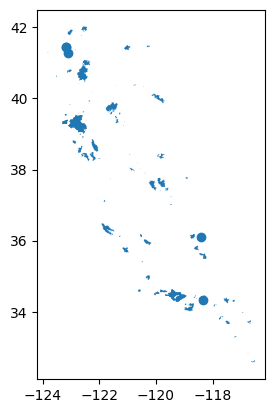

In [3]:
# Define years we care about for our study
STUDY_YEARS = [2016, 2017, 2018]

# Read in US wildfire dataset
fires = gpd.read_file(data_dir / "01_raw_data" / "wfbz_disasters_2000-2025.geojson")

# Filter to only CA fires
fires = fires[fires['wildfire_states'].str.contains('CA')]

# Keep only fires from 2016, 2017, or 2018
fires = fires[fires["wildfire_year"].isin(STUDY_YEARS)]

# Rename wildfire ID column to popexposure expected "ID_hazard"
fires = fires.rename(columns={"ics_id": "ID_hazard"})

# Reset index
fires = fires.reset_index(drop=True)

# Create buffer distance column (distance must be given in meters)
fires["buffer_dist_10km"] = 10_000

# Select only those columns of interest
fires = fires[["ID_hazard", "wildfire_year", "buffer_dist_10km", "geometry"]]

# Save hazard data to GeoJSON files by year
for year in STUDY_YEARS:
    fires_yr = fires[fires["wildfire_year"] == year].reset_index(drop=True)
    fires_yr.to_file(data_dir / "02_interim_data" / f"wildfires_CA_{year}.geojson", driver="GeoJSON")

# Plot hazards from 2016-2018, and show first 5 rows of resulting data
fires.plot()
fires.head()

Our data is ready! This concludes the set up portion of the tutorial. Proceed to `02_demo_example_run.ipynb` to start running `popexposure` functions.